In [1]:
"""
@author: pho
"""
%load_ext autoreload
%autoreload 2
import sys
import time
import importlib
from pathlib import Path
from datetime import datetime

from numba import jit
import numpy as np
import pandas as pd

# required to enable non-blocking interaction:
# %gui qt
# $env:QT_API="pyqt6"
%gui qt5
# from PyQt5.Qt import QApplication
# # start qt event loop
# _instance = QApplication.instance()
# if not _instance:
#     _instance = QApplication([])
# app = _instance
import pyqtgraph as pg
from pyqtgraph.Qt import QtCore, QtGui
import pyqtgraph.opengl as gl # for 3D raster plot

# ## Panel:
import param
import panel as pn
# from panel.interact import interact, interactive, fixed, interact_manual
# from panel.viewable import Viewer
pn.extension()

## Pho's Custom Libraries:
from pyphocorehelpers.general_helpers import get_arguments_as_optional_dict, inspect_callable_arguments
from pyphocorehelpers.function_helpers import compose_functions
from pyphocorehelpers.indexing_helpers import partition, build_spanning_bins, compute_spanning_bins, compute_position_grid_size, compute_paginated_grid_config
from pyphocorehelpers.print_helpers import PrettyPrintable, WrappingMessagePrinter
from pyphocorehelpers.geometry_helpers import compute_data_extent, compute_data_aspect_ratio, corner_points_from_extents
from pyphocorehelpers.DataStructure.dynamic_parameters import DynamicParameters
from pyphocorehelpers.performance_timing_helpers import WrappingPerformanceTimer
from pyphocorehelpers.gui.interaction_helpers import CallbackWrapper

# pyPhoPlaceCellAnalysis:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import NeuropyPipeline # get_neuron_identities
from pyphoplacecellanalysis.General.SessionSelectionAndFiltering import batch_filter_session, build_custom_epochs_filters
from pyphoplacecellanalysis.General.ComputationResults import ComputationResult
from pyphoplacecellanalysis.General.KnownDataSessionTypeProperties import KnownDataSessionTypeProperties
from pyphoplacecellanalysis.General.Pipeline.Stages.Display import DefaultDisplayFunctions
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.Ratemaps import DefaultRatemapDisplayFunctions
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import DefaultDecoderDisplayFunctions
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Spike3DRaster import Spike3DRaster

# from pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_RasterPlot import plot_raster_plot, _display_pyqtgraph_raster_plot, plot_3d_raster_plot

# NeuroPy (Diba Lab Python Repo) Loading
try:
    from neuropy import core

    importlib.reload(core)
except ImportError:
    sys.path.append(r"C:\Users\Pho\repos\NeuroPy")  # Windows
    # sys.path.append('/home/pho/repo/BapunAnalysis2021/NeuroPy') # Linux
    # sys.path.append(r'/Users/pho/repo/Python Projects/NeuroPy') # MacOS
    print("neuropy module not found, adding directory to sys.path. \n >> Updated sys.path.")
    from neuropy import core

# Neuropy:
from neuropy.core.session.data_session_loader import DataSessionLoader
from neuropy.core.session.dataSession import DataSession
from neuropy.core.laps import Laps
from neuropy.analyses.placefields import PlacefieldComputationParameters, perform_compute_placefields
from neuropy.analyses.laps import estimation_session_laps
from neuropy.core.epoch import NamedTimerange

from neuropy.analyses.placefields import PlacefieldComputationParameters, perform_compute_placefields
from neuropy.core.neuron_identities import NeuronIdentity, build_units_colormap, PlotStringBrevityModeEnum
from neuropy.utils.debug_helpers import debug_print_placefield, debug_print_spike_counts, debug_print_subsession_neuron_differences
from neuropy.plotting.ratemaps import enumTuningMap2DPlotVariables
# from neuropy.utils.mixins.time_slicing import verify_non_overlapping, add_PBE_identity
from neuropy.utils.efficient_interval_search import get_non_overlapping_epochs, drop_overlapping

known_data_session_type_dict = {'kdiba':KnownDataSessionTypeProperties(load_function=(lambda a_base_dir: DataSessionLoader.kdiba_old_format_session(a_base_dir)),
                               basedir=Path(r'R:\data\KDIBA\gor01\one\2006-6-07_11-26-53')),
                'bapun':KnownDataSessionTypeProperties(load_function=(lambda a_base_dir: DataSessionLoader.bapun_data_session(a_base_dir)),
                               basedir=Path('R:\data\Bapun\Day5TwoNovel'))
               }
known_data_session_type_dict['kdiba'].post_load_functions = [lambda a_loaded_sess: estimation_session_laps(a_loaded_sess)]

# known_data_session_type_dict['kdiba'].name
# from matplotlib.figure import Figure
# import matplotlib.pyplot as plt
# %matplotlib qt
# from matplotlib.transforms import IdentityTransform

C:\Users\pho\miniconda3\envs\phoviz_ultimate\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
enable_saving_to_disk = False
# common_parent_foldername = Path(r'R:\Dropbox (Personal)\Active\Kamran Diba Lib\Pho-Kamran-Meetings\Final Placemaps 2021-01-14')
common_parent_foldername = Path(r'R:\Dropbox (Personal)\Active\Kamran Diba Lib\Pho-Kamran-Meetings\2022-01-16')

def compute_position_grid_bin_size(x, y, num_bins=(64,64), debug_print=False):
    """ Compute Required Bin size given a desired number of bins in each dimension
    Usage:
        active_grid_bin = compute_position_grid_bin_size(curr_kdiba_pipeline.sess.position.x, curr_kdiba_pipeline.sess.position.y, num_bins=(64, 64)
    """
    out_grid_bin_size, out_bins, out_bins_infos = compute_position_grid_size(x, y, num_bins=num_bins)
    active_grid_bin = tuple(out_grid_bin_size)
    if debug_print:
        print(f'active_grid_bin: {active_grid_bin}') # (3.776841861770752, 1.043326930905373)
    return active_grid_bin

# WARNING! TODO: Changing the smooth values from (1.5, 1.5) to (0.5, 0.5) was the difference between successful running and a syntax error!
# try:
#     active_grid_bin
# except NameError as e:
#     print('setting active_grid_bin = None')
#     active_grid_bin = None
# finally:
#     # active_session_computation_config = PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=active_grid_bin, smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5) # if active_grid_bin is missing, figure out the name
#     active_session_computation_config = PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=active_grid_bin, smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5) # if active_grid_bin is missing, figure out the name

## Dynamic mode:
def _build_active_computation_configs(sess):
    """ _get_computation_configs(curr_kdiba_pipeline.sess)
        # From Diba:
        # (3.777, 1.043) # for (64, 64) bins
        # (1.874, 0.518) # for (128, 128) bins

    """
    # active_grid_bin = compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(64, 64))
    # active_session_computation_config.computation_epochs = None # set the placefield computation epochs to None, using all epochs.
    # return [PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(64, 64)), smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5, computation_epochs = None)]
    # return [PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(128, 128)), smooth=(2.0, 2.0), frate_thresh=0.2, time_bin_size=0.5, computation_epochs = None)]
    return [PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(64, 64)), smooth=(2.0, 2.0), frate_thresh=0.2, time_bin_size=1.0, computation_epochs = None)]
    # return [PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=(3.777, 1.043), smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5, computation_epochs = None)]

    # return [PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(32, 32)), smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5, computation_epochs = None),
    #         PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(64, 64)), smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5, computation_epochs = None),
    #         PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(128, 128)), smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5, computation_epochs = None),
    #        ]



# Bapun Format:

In [ ]:
# curr_bapun_pipeline = NeuropyPipeline(name='bapun_pipeline', session_data_type='bapun', basedir=known_data_session_type_dict['bapun'].basedir, load_function=known_data_session_type_dict['bapun'].load_function)
curr_bapun_pipeline = NeuropyPipeline.init_from_known_data_session_type('bapun', known_data_session_type_dict['bapun'])
active_session_computation_configs = _build_active_computation_configs(curr_bapun_pipeline.sess)
# active_session_computation_config.grid_bin = compute_position_grid_bin_size(curr_bapun_pipeline.sess.position.x, curr_bapun_pipeline.sess.position.y, num_bins=(64, 64))

In [ ]:
# Bapun/DataFrame style session filter functions:
def build_bapun_any_epochs_filters(sess):
    return build_custom_epochs_filters(sess)
    
def build_bapun_any_maze_epochs_filters(sess):
    # all_filters = build_custom_epochs_filters(sess)
    # # print(f'all_filters: {all_filters}')
    # maze_only_filters = dict()
    # for (name, filter_fcn) in all_filters.items():
    #     if 'maze' in name:
    #         maze_only_filters[name] = filter_fcn
    # maze_only_filters = build_custom_epochs_filters(sess, included_epoch_labels=['maze1','maze2'])
    # { key:value for (key,value) in dictOfNames.items() if key % 2 == 0}
    # dict(filter(lambda elem: len(elem[1]) == 6,dictOfNames.items()))
    # maze_only_name_filter_fn = lambda dict: dict(filter(lambda elem: 'maze' in elem[0], dict.items()))
    maze_only_name_filter_fn = lambda names: list(filter(lambda elem: elem.startswith('maze'), names))
    # print(f'callable(maze_only_name_filter_fn): {callable(maze_only_name_filter_fn)}')
    # print(maze_only_name_filter_fn(['pre', 'maze1', 'post1', 'maze2', 'post2']))
    # lambda elem: elem[0] % 2 == 0
    maze_only_filters = build_custom_epochs_filters(sess, included_epoch_labels=maze_only_name_filter_fn)
    # print(f'maze_only_filters: {maze_only_filters}')
    return maze_only_filters

# active_session_filter_configurations = build_bapun_any_epochs_filters(curr_bapun_pipeline.sess)
active_session_filter_configurations = build_bapun_any_maze_epochs_filters(curr_bapun_pipeline.sess)
# print(f'active_session_filter_configurations: {active_session_filter_configurations}')
curr_bapun_pipeline.filter_sessions(active_session_filter_configurations)
for i in np.arange(len(active_session_computation_configs)):
    active_session_computation_configs[i].computation_epochs = None  # set the placefield computation epochs to None, using all epochs.
curr_bapun_pipeline.perform_computations(active_session_computation_configs[0])
curr_bapun_pipeline.prepare_for_display() # TODO: pass a display config
# Set curr_active_pipeline for testing:
curr_active_pipeline = curr_bapun_pipeline

## KDiba Format:

In [3]:
## Data must be pre-processed using the MATLAB script located here: 
# R:\data\KDIBA\gor01\one\IIDataMat_Export_ToPython_2021_11_23.m
# From pre-computed .mat files:
## 07: 
# basedir = r'R:\data\KDIBA\gor01\one\2006-6-07_11-26-53'
# # ## 08:
# basedir = r'R:\data\KDIBA\gor01\one\2006-6-08_14-26-15'
# curr_kdiba_pipeline = NeuropyPipeline(name='kdiba_pipeline', session_data_type='kdiba', basedir=known_data_session_type_dict['kdiba'].basedir, load_function=known_data_session_type_dict['kdiba'].load_function)
curr_kdiba_pipeline = NeuropyPipeline.init_from_known_data_session_type('kdiba', known_data_session_type_dict['kdiba'])
# active_grid_bin = compute_position_grid_bin_size(curr_kdiba_pipeline.sess.position.x, curr_kdiba_pipeline.sess.position.y, num_bins=(64, 64))
# active_session_computation_config.grid_bin = active_grid_bin
active_session_computation_configs = _build_active_computation_configs(curr_kdiba_pipeline.sess)

basedir is already Path object.
	 basepath: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53
	 session_name: 2006-6-07_11-26-53
Loading matlab import file results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.epochs_info.mat... done.
Loading matlab import file results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.position_info.mat... done.
Loading matlab import file results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.spikes.mat... done.
Failure loading .position.npy. Must recompute.

Computing linear positions for all active epochs for session... Saving updated position results results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.position.npy... 2006-6-07_11-26-53.position.npy saved
done.
	 Failure loading .interpolated_spike_positions.npy. Must recompute.

	 Saving updated interpolated spike position results results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.interpolated_spike_positions.npy.

In [ ]:
def build_any_maze_epochs_filters(sess):
    sess.epochs.t_start = 22.26 # exclude the first short period where the animal isn't on the maze yet
    active_session_filter_configurations = {'maze1': lambda x: (x.filtered_by_epoch(x.epochs.get_named_timerange('maze1')), x.epochs.get_named_timerange('maze1')) } # just maze 1
    # active_session_filter_configurations = {'maze1': lambda x: (x.filtered_by_epoch(x.epochs.get_named_timerange('maze1')), x.epochs.get_named_timerange('maze1')),
    #                                     'maze2': lambda x: (x.filtered_by_epoch(x.epochs.get_named_timerange('maze2')), x.epochs.get_named_timerange('maze2')),
    #                                     'maze': lambda x: (x.filtered_by_epoch(NamedTimerange(name='maze', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]])), NamedTimerange(name='maze', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]]))
    #                                    }
    return active_session_filter_configurations

active_session_filter_configurations = build_any_maze_epochs_filters(curr_kdiba_pipeline.sess)
curr_kdiba_pipeline.filter_sessions(active_session_filter_configurations)
for i in np.arange(len(active_session_computation_configs)):
    active_session_computation_configs[i].computation_epochs = None # add the laps epochs to all of the computation configs.

curr_kdiba_pipeline.perform_computations(active_session_computation_configs[0])
curr_kdiba_pipeline.prepare_for_display() # TODO: pass a display config
# set curr_active_pipeline for testing:
curr_active_pipeline = curr_kdiba_pipeline


In [4]:
def build_pyramidal_epochs_filters(sess):
    sess.epochs.t_start = 22.26 # exclude the first short period where the animal isn't on the maze yet
    active_session_filter_configurations = {'maze1': lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(x.epochs.get_named_timerange('maze1')), x.epochs.get_named_timerange('maze1')),
                                        'maze2': lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(x.epochs.get_named_timerange('maze2')), x.epochs.get_named_timerange('maze2')),
                                        'maze': lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(NamedTimerange(name='maze', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]])), NamedTimerange(name='maze', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]]))
                                       }
    return active_session_filter_configurations

active_session_filter_configurations = build_pyramidal_epochs_filters(curr_kdiba_pipeline.sess)


is_non_overlapping_lap = get_non_overlapping_epochs(curr_kdiba_pipeline.sess.laps.to_dataframe()[['start','stop']].to_numpy())
only_good_laps_df = curr_kdiba_pipeline.sess.laps.to_dataframe()[is_non_overlapping_lap]
curr_kdiba_pipeline.sess.laps = Laps(only_good_laps_df) # replace the laps object with the filtered one


lap_specific_epochs = curr_kdiba_pipeline.sess.laps.as_epoch_obj()
any_lap_specific_epochs = lap_specific_epochs.label_slice(lap_specific_epochs.labels[np.arange(len(curr_kdiba_pipeline.sess.laps.lap_id))])
even_lap_specific_epochs = lap_specific_epochs.label_slice(lap_specific_epochs.labels[np.arange(0, len(curr_kdiba_pipeline.sess.laps.lap_id), 2)])
odd_lap_specific_epochs = lap_specific_epochs.label_slice(lap_specific_epochs.labels[np.arange(1, len(curr_kdiba_pipeline.sess.laps.lap_id), 2)])


# Copy the active session_computation_config:
for i in np.arange(len(active_session_computation_configs)):
    active_session_computation_configs[i].computation_epochs = any_lap_specific_epochs # add the laps epochs to all of the computation configs.

curr_kdiba_pipeline.filter_sessions(active_session_filter_configurations)
curr_kdiba_pipeline.perform_computations(active_session_computation_configs[0]) # Causes "IndexError: index 59 is out of bounds for axis 0 with size 59"
curr_kdiba_pipeline.prepare_for_display() # TODO: pass a display config
# set curr_active_pipeline for testing:
curr_active_pipeline = curr_kdiba_pipeline

c:\users\pho\repos\neuropy\neuropy\core\laps.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_df[['lap_id']] = laps_df[['lap_id']].astype('int')
c:\users\pho\repos\neuropy\neuropy\core\laps.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_df[['start_spike_index', 'end_spike_index']] = laps_df[['start_spike_index', 'end_spike_index']].astype('int')
c:\users\pho\repos\neuropy\neuropy\core\laps.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Applying session filter named "maze1"...
Constraining to units with type: pyramidal
Constraining to epoch with times (start: 22.26, end: 1739.1533641185379)
computing neurons mua for session...



c:\users\pho\repos\neuropy\neuropy\core\laps.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_df[['lap_id']] = laps_df[['lap_id']].astype('int')
c:\users\pho\repos\neuropy\neuropy\core\laps.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_df[['start_spike_index', 'end_spike_index']] = laps_df[['start_spike_index', 'end_spike_index']].astype('int')
c:\users\pho\repos\neuropy\neuropy\core\laps.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Applying session filter named "maze2"...
Constraining to units with type: pyramidal
Constraining to epoch with times (start: 1739.1533641185379, end: 1932.4200048116618)
computing neurons mua for session...



c:\users\pho\repos\neuropy\neuropy\core\laps.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_df[['lap_id']] = laps_df[['lap_id']].astype('int')
c:\users\pho\repos\neuropy\neuropy\core\laps.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_df[['start_spike_index', 'end_spike_index']] = laps_df[['start_spike_index', 'end_spike_index']].astype('int')
c:\users\pho\repos\neuropy\neuropy\core\laps.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Applying session filter named "maze"...
Constraining to units with type: pyramidal
Constraining to epoch with times (start: 22.26, end: 1932.4200048116618)
computing neurons mua for session...



c:\users\pho\repos\neuropy\neuropy\core\laps.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_df[['lap_id']] = laps_df[['lap_id']].astype('int')
c:\users\pho\repos\neuropy\neuropy\core\laps.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_df[['start_spike_index', 'end_spike_index']] = laps_df[['start_spike_index', 'end_spike_index']].astype('int')
c:\users\pho\repos\neuropy\neuropy\core\laps.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Performing single_computation on filtered_session with filter named "maze1"...
Recomputing active_epoch_placefields... pre speed filtering: 20202 spikes.
post speed filtering: 13268 spikes.
	 done.
Recomputing active_epoch_placefields2D... pre speed filtering: 20202 spikes.
post speed filtering: 13529 spikes.
	 done.
Performing perform_registered_computations(...) with 5 registered_computation_functions...


c:\users\pho\repos\pyphoplacecellanalysis\src\pyphoplacecellanalysis\Analysis\reconstruction.py:217: RuntimeWarning: divide by zero encountered in true_divide
  return C * np.exp(numerator/denominator)


Performing single_computation on filtered_session with filter named "maze2"...
Recomputing active_epoch_placefields... pre speed filtering: 545 spikes.
post speed filtering: 314 spikes.
	 done.
Recomputing active_epoch_placefields2D... pre speed filtering: 545 spikes.
post speed filtering: 329 spikes.
	 done.
Performing perform_registered_computations(...) with 5 registered_computation_functions...
Performing single_computation on filtered_session with filter named "maze"...
Recomputing active_epoch_placefields... pre speed filtering: 20747 spikes.
post speed filtering: 13582 spikes.
	 done.
Recomputing active_epoch_placefields2D... pre speed filtering: 20747 spikes.
post speed filtering: 13858 spikes.
	 done.
Performing perform_registered_computations(...) with 5 registered_computation_functions...


c:\users\pho\repos\pyphoplacecellanalysis\src\pyphoplacecellanalysis\Analysis\reconstruction.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  C_tau_n = 1.0 / np.sum(un_normalized_result) # normalize the result
c:\users\pho\repos\pyphoplacecellanalysis\src\pyphoplacecellanalysis\Analysis\reconstruction.py:178: RuntimeWarning: invalid value encountered in multiply
  result = C_tau_n * un_normalized_result
c:\users\pho\repos\pyphoplacecellanalysis\src\pyphoplacecellanalysis\Analysis\reconstruction.py:217: RuntimeWarning: divide by zero encountered in true_divide
  return C * np.exp(numerator/denominator)
c:\users\pho\repos\pyphoplacecellanalysis\src\pyphoplacecellanalysis\Analysis\reconstruction.py:217: RuntimeWarning: divide by zero encountered in true_divide
  return C * np.exp(numerator/denominator)


# Common: Optional Saving

In [5]:
curr_epoch_labels = list(curr_active_pipeline.sess.epochs.labels) # ['pre', 'maze1', 'post1', 'maze2', 'post2']
curr_named_timeranges = [curr_active_pipeline.sess.epochs.get_named_timerange(a_label) for a_label in curr_epoch_labels]

curr_named_timeranges

all_filters_list = list(curr_active_pipeline.filtered_sessions.keys())
all_filters_list

['maze1', 'maze2', 'maze']

In [6]:
# Analyze PBEs by looping through the filtered epochs:


# curr_kdiba_pipeline.sess.spikes_df.spikes.time_variable_name # 't_rel_seconds' 
# active_timestamps = curr_kdiba_pipeline.sess.spikes_df[curr_kdiba_pipeline.sess.spikes_df.spikes.time_variable_name].copy().to_numpy() # get the timestamps column using the time_variable_name property. It's 't_rel_seconds' for kdiba-format data for example
# active_timestamps

curr_kdiba_pipeline.sess.spikes_df[curr_kdiba_pipeline.sess.spikes_df['PBE_id'] > -1]

# curr_epoch_duration
# determine_event_interval_is_included(...)

,t,t_seconds,t_rel_seconds,shank,cluster,aclu,qclu,x,y,speed,...,lap,maze_relative_lap,maze_id,cell_type,flat_spike_idx,x_loaded,y_loaded,lin_pos,unit_id,PBE_id
11035,636150.0,506937.178567,19.542518,4,4,35,5,228.107986,131.252612,4.732323,...,-1,-1,1,NeuronType.CONTAMINATED,11035,0.822984,0.459296,-45.659293,33,0
11036,636207.0,506937.180318,19.544269,3,8,30,5,228.104571,131.245321,4.730808,...,-1,-1,1,NeuronType.CONTAMINATED,11036,0.823039,0.459278,-45.656698,28,0
11037,636261.0,506937.181977,19.545928,11,6,60,5,228.101335,131.238414,4.729372,...,-1,-1,1,NeuronType.CONTAMINATED,11037,0.823090,0.459261,-45.654239,58,0
11038,636265.0,506937.182100,19.546051,7,5,41,5,228.101096,131.237902,4.729266,...,-1,-1,1,NeuronType.CONTAMINATED,11038,0.823094,0.459260,-45.654057,39,0
11039,636343.0,506937.184496,19.548447,7,5,41,5,228.096423,131.227926,4.727192,...,-1,-1,1,NeuronType.CONTAMINATED,11039,0.823169,0.459235,-45.650506,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932168,64355771.0,508894.644322,1977.008273,11,6,60,5,75.848150,140.227136,0.000000,...,-1,-1,2,NeuronType.CONTAMINATED,932168,NaN,NaN,NaN,58,241
932169,64355841.0,508894.646472,1977.010423,8,14,54,5,75.848150,140.227136,0.000000,...,-1,-1,2,NeuronType.CONTAMINATED,932169,NaN,NaN,NaN,52,241
932170,64355910.0,508894.648592,1977.012543,11,6,60,5,75.848150,140.227136,0.000000,...,-1,-1,2,NeuronType.CONTAMINATED,932170,NaN,NaN,NaN,58,241
932171,64355981.0,508894.650773,1977.014724,2,8,16,5,75.848150,140.227136,0.000000,...,-1,-1,2,NeuronType.CONTAMINATED,932171,NaN,NaN,NaN,14,241


In [34]:
## Testing burst detection
# curr_active_pipeline.sess.spikes_df.spikes.neuron_ids

# grouped = curr_active_pipeline.sess.spikes_df.groupby('aclu')

# neuron_split_spike_dfs = [spk_df.groupby('aclu').get_group(neuron_id)[['t','x','y','lin_pos']] for neuron_id in active_epoch_session.neuron_ids] # dataframes split for each ID:
# neuron_split_spike_dfs = curr_active_pipeline.sess.spikes_df.spikes.get_split_by_unit()

# Compute the inter-spike-intervals (ISIs) for each cell/unit separately. Meaning the list should be the difference from the current spike to the last spike of the previous unit.
# neuron_split_spike_ISIs = [neuron_split_spike_dfs[neuron_id]['t_rel_seconds'].diff() for neuron_id in curr_active_pipeline.sess.neuron_ids] # dataframes split for each ID:
# neuron_split_spike_ISIs

def _add_same_cell_ISI_column(spikes_df):
    """ Compute the inter-spike-intervals (ISIs) for each cell/unit separately. Meaning the list should be the difference from the current spike to the last spike of the previous unit.
        spikes: curr_active_pipeline.sess.spikes_df
        adds column 'scISI' to spikes df.
    """
    spikes_df['scISI'] = -1 # initialize the 'scISI' column (same-cell Intra-spike-interval) to -1

    for (i, a_cell_id) in enumerate(spikes_df.spikes.neuron_ids):
        # loop through the cell_ids
        curr_df = spikes_df.groupby('aclu').get_group(a_cell_id)
        # curr_df = neuron_split_spike_dfs[i]
        # curr_series_differences = neuron_split_spike_dfs[neuron_id]['t_rel_seconds'].diff()
        curr_series_differences = curr_df['t_rel_seconds'].diff() # These are the ISIs
        #set the properties for the points in question:
        spikes_df.loc[curr_df.index,'scISI'] = curr_series_differences
        # spikes_df.loc[:,'scISI'] = curr_series_differences

_add_same_cell_ISI_column(curr_active_pipeline.sess.spikes_df)


# grouped['t_rel_seconds'].diff()

# .diff()
curr_active_pipeline.sess.spikes_df

In [39]:
curr_active_pipeline.sess.spikes_df.dtypes
curr_active_pipeline.sess.spikes_df.memory_usage(deep=True)  # memory usage in bytes

Index                     128
t                     7460784
t_seconds             7460784
t_rel_seconds         7460784
shank                 3730392
cluster               3730392
aclu                  3730392
qclu                  3730392
x                     7460784
y                     7460784
speed                 7460784
traj                  3730392
lap                   3730392
maze_relative_lap     3730392
maze_id               3730392
cell_type            37303920
flat_spike_idx        3730392
x_loaded              7460784
y_loaded              7460784
lin_pos               7460784
unit_id               3730392
PBE_id                7460784
scISI                 7460784
dtype: int64

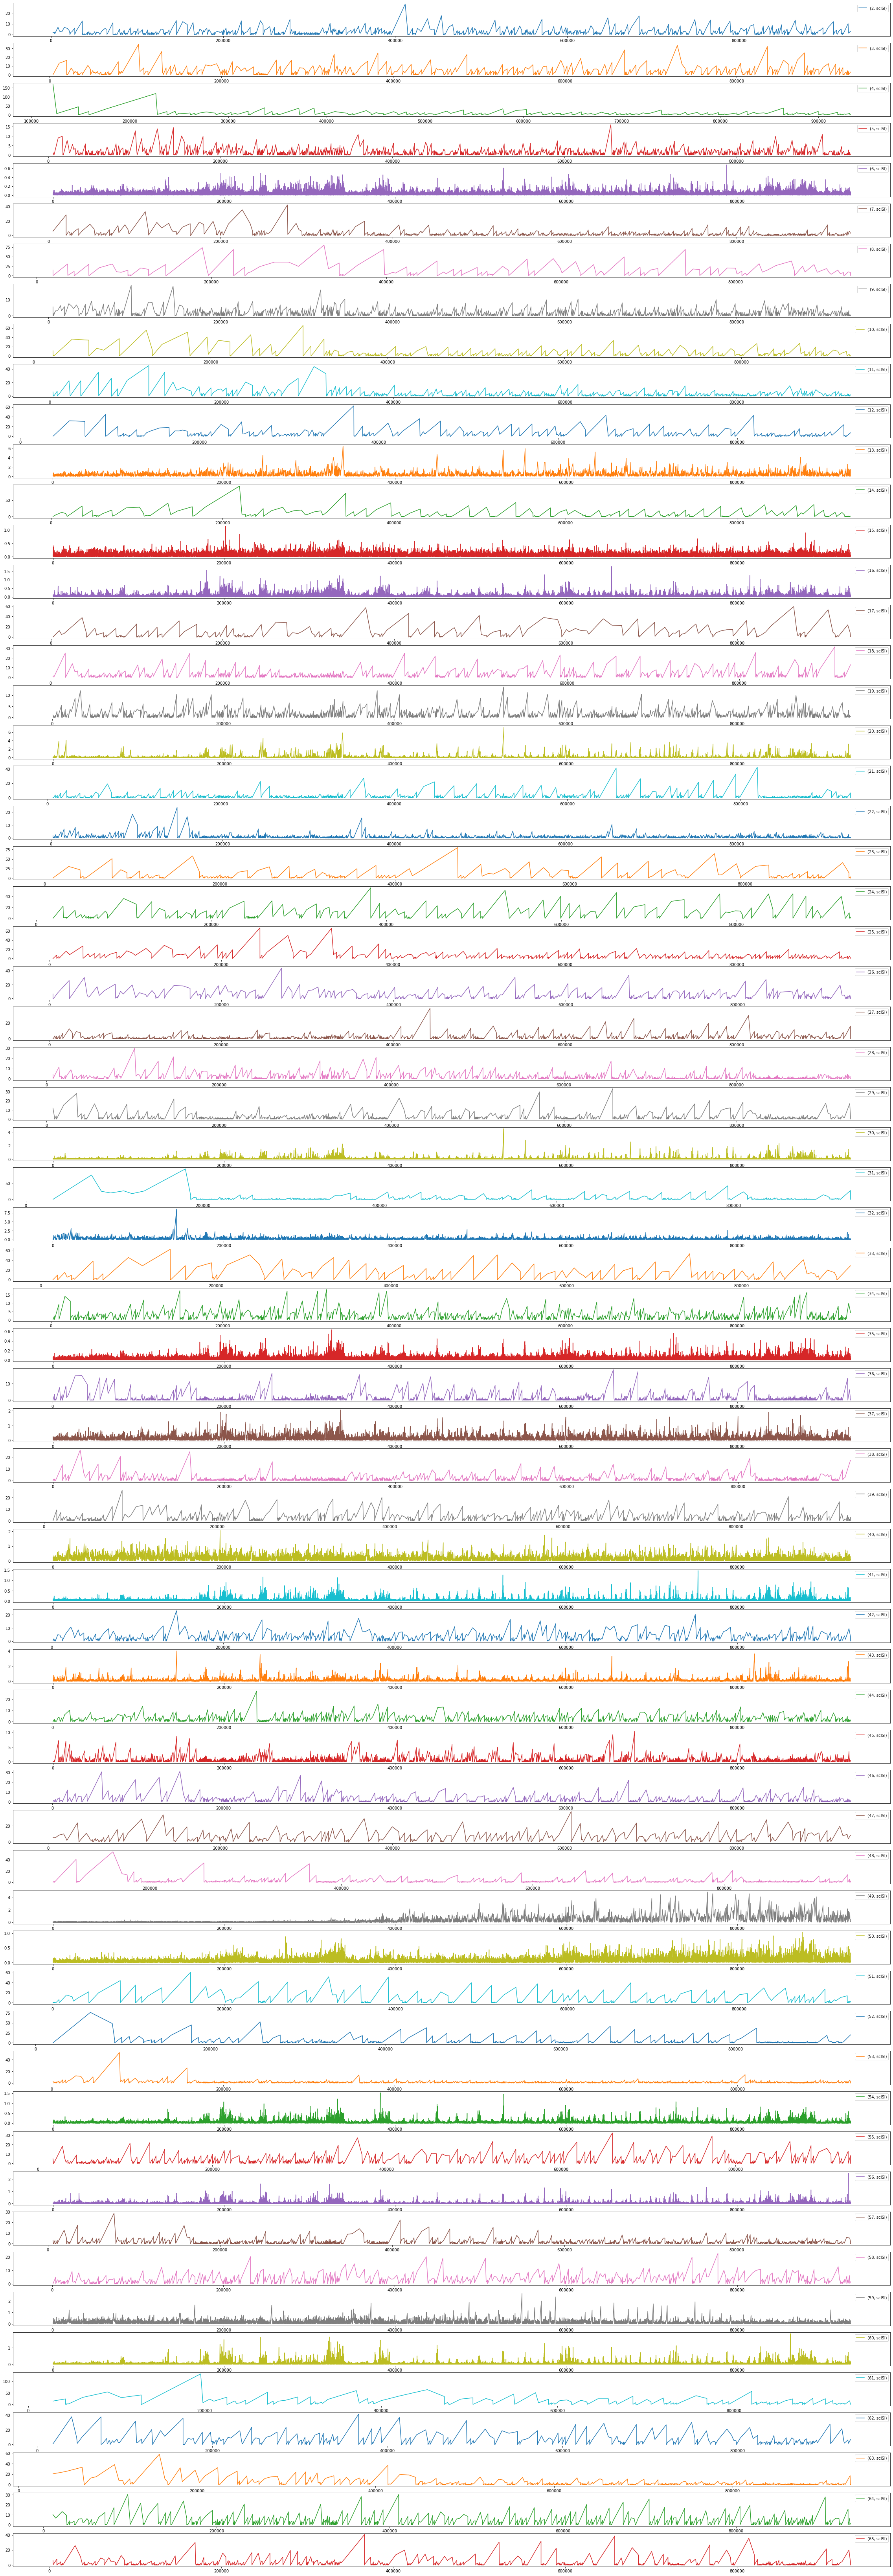

In [38]:
# out_figs = curr_active_pipeline.sess.spikes_df.plot.hist(by='aclu', column='scISI', bins=12, sharex=True, alpha=0.5, figsize=(40, 120))
# out_figs = curr_active_pipeline.sess.spikes_df.plot.hist(by='aclu', column='scISI', bins=12, alpha=0.5, figsize=(40, 120))
# out_figs = curr_active_pipeline.sess.spikes_df.plot.hist(column='scISI', bins=12, alpha=0.5, figsize=(40, 120))
# out_figs = curr_active_pipeline.sess.spikes_df.plot.box(column=['scISI'], by='aclu', figsize=(40, 120)) # boxplots side-by-side

# out_figs = curr_active_pipeline.sess.spikes_df.plot.kde(column=['scISI'], by='aclu', figsize=(40, 120)) # Not working
out_figs = curr_active_pipeline.sess.spikes_df.plot(column=['scISI'], by='aclu', figsize=(40, 120)) # boxplots side-by-side
# .plot(xlabel="new x", ylabel="new y");


In [ ]:
#TODO: Works, but need to convert into the computation function format or find a new place to put it. It operates on the entire pipeline while currently computation functions are limited to operating on one stage at a time.
def _perform_PBE_stats(active_pipeline, debug_print = False):
    """ # Analyze PBEs by looping through the filtered epochs:
        This whole implementation seems silly and inefficient        
        Can't I use .agg(['count', 'mean']) or something? 
    """
    all_epochs_labels = []
    all_epochs_total_durations = []
    all_epochs_n_pbes = []
    all_epochs_pbe_duration_lists = []
    all_epochs_cummulative_pbe_durations = []
    all_epochs_mean_pbe_durations = []
    all_epochs_full_pbe_spiketrain_lists = []
    all_epochs_pbe_num_spikes_lists = []
    all_epochs_intra_pbe_interval_lists = []
    
    for (name, filtered_sess) in active_pipeline.filtered_sessions.items():
        # interested in analyzing both the filtered_sess.pbe and the filtered_sess.spikes_df (as they relate to the PBEs)
        all_epochs_labels.append(name)
        curr_named_time_range = active_pipeline.sess.epochs.get_named_timerange(name) # for 'maze' key, the total duration is being set to array([], dtype=float64) for some reason. all_epochs_total_durations: [1716.8933641185379, 193.26664069312392, array([], dtype=float64)]
        
        if not np.isscalar(curr_named_time_range.duration):
            # for 'maze' key, the total duration is being set to array([], dtype=float64) for some reason. all_epochs_total_durations: [1716.8933641185379, 193.26664069312392, array([], dtype=float64)]
            curr_named_time_range = NamedTimerange(name='maze', start_end_times=[active_pipeline.sess.epochs['maze1'][0], active_pipeline.sess.epochs['maze2'][1]])
        
        curr_epoch_duration = curr_named_time_range.duration
        all_epochs_total_durations.append(curr_epoch_duration) # TODO: this should be in seconds (or at least the same units as the PBE durations)... actually this might be right.
        # Computes the intervals between each PBE:
        curr_intra_pbe_intervals = filtered_sess.pbe.starts[1:] - filtered_sess.pbe.stops[:-1]
        all_epochs_intra_pbe_interval_lists.append(curr_intra_pbe_intervals)
        all_epochs_n_pbes.append(filtered_sess.pbe.n_epochs)
        all_epochs_pbe_duration_lists.append(filtered_sess.pbe.durations)
        all_epochs_cummulative_pbe_durations.append(np.sum(filtered_sess.pbe.durations))
        all_epochs_mean_pbe_durations.append(np.nanmean(filtered_sess.pbe.durations))
        # filtered_sess.spikes_df.PBE_id
        curr_pbe_only_spikes_df = filtered_sess.spikes_df[filtered_sess.spikes_df.PBE_id > -1].copy()
        unique_PBE_ids = np.unique(curr_pbe_only_spikes_df['PBE_id'])
        flat_PBE_ids = [int(id) for id in unique_PBE_ids]
        num_unique_PBE_ids = len(flat_PBE_ids)
        # groups the spikes_df by PBEs:
        curr_pbe_grouped_spikes_df = curr_pbe_only_spikes_df.groupby(['PBE_id'])
        curr_spiketrains = list()
        curr_PBE_spiketrain_num_spikes = list()
        for i in np.arange(num_unique_PBE_ids):
            curr_PBE_id = flat_PBE_ids[i] # actual cell ID
            #curr_flat_cell_indicies = (flat_spikes_out_dict['aclu'] == curr_cell_id) # the indicies where the cell_id matches the current one
            curr_PBE_dataframe = curr_pbe_grouped_spikes_df.get_group(curr_PBE_id)
            curr_PBE_num_spikes = np.shape(curr_PBE_dataframe)[0] # the number of spikes in this PBE
            curr_PBE_spiketrain_num_spikes.append(curr_PBE_num_spikes)
            curr_spiketrains.append(curr_PBE_dataframe['t'].to_numpy())

        curr_PBE_spiketrain_num_spikes = np.array(curr_PBE_spiketrain_num_spikes)
        all_epochs_pbe_num_spikes_lists.append(curr_PBE_spiketrain_num_spikes)
        curr_spiketrains = np.array(curr_spiketrains, dtype='object')
        all_epochs_full_pbe_spiketrain_lists.append(curr_spiketrains)
        if debug_print:
            print(f'name: {name}, filtered_sess.pbe: {filtered_sess.pbe}')

    if debug_print:
        print(f'all_epochs_n_pbes: {all_epochs_n_pbes}, all_epochs_mean_pbe_durations: {all_epochs_mean_pbe_durations}, all_epochs_cummulative_pbe_durations: {all_epochs_cummulative_pbe_durations}, all_epochs_total_durations: {all_epochs_total_durations}')
        # all_epochs_n_pbes: [3152, 561, 1847, 832, 4566], all_epochs_mean_pbe_durations: [0.19560881979695527, 0.22129233511594312, 0.19185056848946497, 0.2333112980769119, 0.1987152869032212]

    all_epochs_pbe_occurance_rate = [(float(all_epochs_total_durations[i]) / float(all_epochs_n_pbes[i])) for i in np.arange(len(all_epochs_n_pbes))]
    all_epochs_pbe_percent_duration = [(float(all_epochs_total_durations[i]) / float(all_epochs_cummulative_pbe_durations[i])) for i in np.arange(len(all_epochs_n_pbes))]    
    all_epoch_mean_num_pbe_spikes = [np.nanmean(pbe_spike_counts) for pbe_spike_counts in all_epochs_pbe_num_spikes_lists] # [3151, 561, 1847, 831, 4563]
    all_epoch_std_num_pbe_spikes = [np.nanstd(pbe_spike_counts) for pbe_spike_counts in all_epochs_pbe_num_spikes_lists] # [11.638970035733648, 15.013817202645336, 15.5123897729991, 15.113395025612247, 11.473087401691878]
    # [20.429704855601397, 27.338680926916222, 23.748781808337846, 25.673886883273166, 20.38614946307254]
    # Build the final output result dataframe:
    pbe_analyses_result_df = pd.DataFrame({'n_pbes':all_epochs_n_pbes, 'mean_pbe_durations': all_epochs_mean_pbe_durations, 'cummulative_pbe_durations':all_epochs_cummulative_pbe_durations, 'epoch_total_duration':all_epochs_total_durations,
                'pbe_occurance_rate':all_epochs_pbe_occurance_rate, 'pbe_percent_duration':all_epochs_pbe_percent_duration,
                'mean_num_pbe_spikes':all_epoch_mean_num_pbe_spikes, 'stddev_num_pbe_spikes':all_epoch_std_num_pbe_spikes}, index=all_epochs_labels)
    # temporary: this isn't how the returns work for other computation functions:
    all_epochs_info = [all_epochs_full_pbe_spiketrain_lists, all_epochs_pbe_num_spikes_lists, all_epochs_intra_pbe_interval_lists] # list version
    # all_epochs_info = {'all_epochs_full_pbe_spiketrain_lists':all_epochs_full_pbe_spiketrain_lists, 'all_epochs_pbe_num_spikes_lists':all_epochs_pbe_num_spikes_lists, 'all_epochs_intra_pbe_interval_lists':all_epochs_intra_pbe_interval_lists} # dict version
    return pbe_analyses_result_df, all_epochs_info

pbe_analyses_result_df, [all_epochs_full_pbe_spiketrain_lists, all_epochs_pbe_num_spikes_lists, all_epochs_intra_pbe_interval_lists] = _perform_PBE_stats(curr_active_pipeline, debug_print=False) # all_epochs_n_pbes: [206, 31, 237], all_epochs_mean_pbe_durations: [0.2209951456310722, 0.23900000000001073, 0.22335021097046923], all_epochs_cummulative_pbe_durations: [45.52500000000087, 7.409000000000333, 52.934000000001205], all_epochs_total_durations: [1716.8933641185379, 193.26664069312392, 1910.1600048116618]

pbe_analyses_result_df
# pbe_analyses_result_df.to_clipboard(sep=',') 

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_SimplePlot import plot_simple_graph

[p1], win, app = plot_simple_graph(all_epochs_intra_pbe_interval_lists[0])

for (idx, named_range) in enumerate(curr_named_timeranges):
    # interested in analyzing both the filtered_sess.pbe and the filtered_sess.spikes_df (as they relate to the PBEs)
    p1.plot(all_epochs_intra_pbe_interval_lists[idx] + (300 * idx), pen=(255,0,0), name=named_range.name)

# p1.plot(np.random.normal(size=100), pen=(255,0,0), name="Red curve")
# p1.plot(np.random.normal(size=110)+5, pen=(0,255,0), name="Green curve")
# p1.plot(np.random.normal(size=120)+10, pen=(0,0,255), name="Blue curve")

# def plot_simple_graph(y=np.random.normal(size=100))
#     app = pg.mkQApp("Plotting Example")
#     #mw = QtGui.QMainWindow()
#     #mw.resize(800,800)
#     
#     win = pg.GraphicsLayoutWidget(show=True, title="Basic plotting examples")
#     win.resize(1000,600)
#     win.setWindowTitle('pyqtgraph example: Plotting')
#     
#     # Enable antialiasing for prettier plots
#     pg.setConfigOptions(antialias=True)
#     
#     p1 = win.addPlot(title="Basic array plotting", y=y)
#     
#     return app, win, [p1]

In [ ]:
# Find all spikes that occur during both a PBE & a lap on the track:

# curr_active_pipeline.sess.spikes_df[(curr_active_pipeline.sess.spikes_df['PBE_id'] > -1)] # & (curr_active_pipeline.sess.spikes_df['lap'] != -1)
during_lap_and_PBE_spikes_df = curr_active_pipeline.sess.spikes_df[(curr_active_pipeline.sess.spikes_df['PBE_id'] > -1) & (curr_active_pipeline.sess.spikes_df['lap'] != -1)]
# curr_active_pipeline.sess.spikes_df[(curr_active_pipeline.sess.spikes_df['lap'] > -1)]
during_lap_and_PBE_spikes_df

# updated_spikes_df = curr_active_pipeline.sess.compute_PBEs_spikes_df(curr_active_pipeline.sess.spikes_df, curr_active_pipeline.sess.pbe.to_dataframe())
# updated_spikes_df[(updated_spikes_df['PBE_id'] > -1)]
# curr_active_pipeline.sess.spikes_df[(curr_active_pipeline.sess.spikes_df['PBE_id'] > -1)]
# curr_active_pipeline.sess.spikes_df

# group by Team, get mean, min, and max value of Age for each value of Team.
grouped_single = during_lap_and_PBE_spikes_df.groupby('lap').agg({'PBE_id': ['mean', 'min', 'max']})
grouped_single = grouped_single.reset_index()
print(grouped_single)

In [ ]:
## 3D Spike Train Visualization
# import pyqtgraph.opengl as gl # for 3D raster plot
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Spike3DRaster import Spike3DRaster

# importlib.reload(pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_RasterPlot)

curr_epoch_name = 'maze1'
curr_epoch = curr_active_pipeline.filtered_epochs[curr_epoch_name] # <NamedTimerange: {'name': 'maze1', 'start_end_times': array([  22.26      , 1739.15336412])};>
curr_sess = curr_active_pipeline.filtered_sessions[curr_epoch_name]
curr_spikes_df = curr_sess.spikes_df


spike_raster_plt = Spike3DRaster(curr_spikes_df, window_duration=4.0, window_start_time=30.0, neuron_colors=None)
# spike_raster_plt = Spike3DRaster(curr_spikes_df, window_duration=0.2, window_start_time=30.0)

# spike_raster_plt.animation()
# spike_raster_plt = None

In [ ]:
print(f'spike_raster_plt.spikes_window.active_time_window: {spike_raster_plt.spikes_window.active_time_window}')
# spike_raster_plt.spikes_window.active_window_start_time = 50.0
spike_raster_plt.spikes_window.update_window_start(90.0)
print(f'spike_raster_plt.spikes_window.active_time_window: {spike_raster_plt.spikes_window.active_time_window}')

In [ ]:
curr_active_pipeline.registered_computation_function_names
# ['_perform_placefield_overlap_computation',
#  '_perform_firing_rate_trends_computation',
#  '_perform_extended_statistics_computation',
#  '_perform_two_step_position_decoding_computation',
#  '_perform_position_decoding_computation']


curr_active_pipeline.registered_display_function_names
# ['_display_1d_placefield_validations',
#  '_display_2d_placefield_result_plot_ratemaps_2D',
#  '_display_2d_placefield_result_plot_raw',
#  '_display_3d_image_plotter',
#  '_display_3d_interactive_custom_data_explorer',
#  '_display_3d_interactive_spike_and_behavior_browser',
#  '_display_3d_interactive_tuning_curves_plotter',
#  '_display_normal',
#  '_display_placemaps_pyqtplot_2D',
#  '_display_decoder_result',
#  '_display_plot_most_likely_position_comparisons',
#  '_display_two_step_decoder_prediction_error_2D',
#  '_display_two_step_decoder_prediction_error_animated_2D']


# all_fcn_tuples[0]
# [a_name for (a_name, a_fn) in all_fcn_tuples]

# Common: Display
Common visualization and display functions for both forms of data/pipelines:

In [5]:
list(curr_active_pipeline.computation_results.keys()) # ['maze1', 'maze2']

['maze1', 'maze2', 'maze']

In [ ]:
active_config_name = 'maze1'
# active_config_name = 'maze'

# Get relevant variables:
# curr_active_pipeline is set above, and usable here
sess: DataSession = curr_active_pipeline.filtered_sessions[active_config_name]
pf = curr_active_pipeline.computation_results[active_config_name].computed_data['pf1D']
active_one_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data['pf2D_Decoder']
active_two_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_TwoStepDecoder', None)
active_measured_positions = curr_active_pipeline.computation_results[active_config_name].sess.position.to_dataframe()

In [ ]:
# Compare curr_active_pipeline.filtered_sessions[active_config_name] and 
# from pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_DataTreeWidget import plot_dataTreeWidget
#
# print(f'curr_active_pipeline.filtered_sessions[active_config_name]: {curr_active_pipeline.filtered_sessions[active_config_name]}')
# print(f'curr_active_pipeline.computation_results[active_config_name].sess: {curr_active_pipeline.computation_results[active_config_name].sess}')
#
# filtered_sessions_tree, filtered_sessions_app = plot_dataTreeWidget(data={'filtered_sessions[active_config_name]':curr_active_pipeline.filtered_sessions[active_config_name].to_dict()}, title='PhoOutputDataTreeApp - filtered_sessions[active_config_name]')
# tree, app = plot_dataTreeWidget(data={'computation_results[active_config_name].sess':curr_active_pipeline.computation_results[active_config_name].sess.to_dict()}, title='PhoOutputDataTreeApp- curr_active_pipeline.computation_results[active_config_name].sess')

# pg.exec()

# sess.ripple
# sess.mua
if sess.pbe is None:
    sess.pbe = DataSession.compute_pbe_epochs(sess, save_on_compute=False)
    
sess.pbe

In [ ]:

if curr_active_pipeline.filtered_sessions['maze2'].pbe is None:
    curr_active_pipeline.filtered_sessions['maze2'].pbe = DataSession.compute_pbe_epochs(curr_active_pipeline.filtered_sessions['maze2'], save_on_compute=False)
    
curr_active_pipeline.filtered_sessions['maze2'].pbe

In [ ]:
display_output = dict()

In [ ]:
pActiveTuningCurvesPlotter = None
display_output = curr_active_pipeline.display(DefaultDisplayFunctions._display_3d_interactive_tuning_curves_plotter, active_config_name, extant_plotter=display_output.get('plotter', None)) # Works now!
# display_output = curr_active_pipeline.display(DefaultDisplayFunctions._display_3d_interactive_tuning_curves_plotter, active_config_name, extant_plotter=pActiveTuningCurvesPlotter) # Works now!
# pActiveTuningCurvesPlotter = display_output['plotter']
display_output['pane'] # doesn't seem to work to control the output anymore!
# display_output['ipcDataExplorer'].debug_logging = True
# InteractivePlaceCellDataExplorer.debug_logging = True

In [ ]:
# display_output['ipcDataExplorer'].change_unit_spikes_included(cell_IDXs=[0, 1, 2, 3], are_included=[True, True, True, True])
# display_output['ipcDataExplorer'].test_toggle_cell_spikes_visibility()
# display_output['ipcDataExplorer']._show_all_tuning_curves()
# display_output['ipcDataExplorer'].update_active_placefields([])


# display_output['ipcDataExplorer'].active_neuron_render_configs # .isVisible is wrong for every value in this array.
display_output['ipcDataExplorer'].apply_tuning_curve_configs()
# """ display_output['ipcDataExplorer'].active_neuron_render_configs:
        # [SingleNeuronPlottingExtended(color='#843c39', extended_values_dictionary={}, isVisible=True, name='2', spikesVisible=False),
        #  SingleNeuronPlottingExtended(color='#9d514e', extended_values_dictionary={}, isVisible=True, name='3', spikesVisible=False),
        # ...
        # ]
# """
# display_output['ipcDataExplorer'].active_tuning_curve_render_configs
# """ display_output['ipcDataExplorer'].active_tuning_curve_render_configs:
#     [SingleNeuronPlottingExtended(color='#843c39', extended_values_dictionary={}, isVisible=True, name='2', spikesVisible=False),
#      SingleNeuronPlottingExtended(color='#9d514e', extended_values_dictionary={}, isVisible=True, name='3', spikesVisible=False),
#      ...
#      ]
# """

# display_output['ipcDataExplorer']._show_tuning_curve(5)

# debug_disable_all_gui_controls 

# display_output['ipcDataExplorer'].active_tuning_curve_render_configs # [SingleNeuronPlottingExtended(color='#843c39', extended_values_dictionary={}, isVisible=False, name='2', spikesVisible=False), ... ]
# display_output['ipcDataExplorer'].cell_ids
# display_output['ipcDataExplorer'].clear_spikes_exclusion_mask()
# display_output['ipcDataExplorer'].pf_names

# display_output['ipcDataExplorer'].change_unit_spikes_included(cell_IDs=display_output['ipcDataExplorer'].cell_ids, are_included=np.full_like(display_output['ipcDataExplorer'].cell_ids, True))
# display_output['ipcDataExplorer'].perform_plot_location_point()
# neuron_config_indicies: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
#        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
#        34, 35, 36, 37, 38])
# display_output['ipcDataExplorer'].unmask_spikes_from_render([2, 3, 4])

In [ ]:
from pyphoplacecellanalysis.GUI.Qt.qt_placefield import build_all_placefield_output_panels
# display_output = curr_active_pipeline.display(DefaultDisplayFunctions._display_3d_interactive_tuning_curves_plotter, active_config_name, extant_plotter=display_output.get('pActiveTuningCurvesPlotter', None)) # Works now!

# pActiveTuningCurvesPlotter
# display_output['ipcDataExplorer'].active_tuning_curve_render_configs # array of SingleNeuronPlottingExtended objects

## TODO: try to build these UI elements in the ipcDataExplorer itself instead of externally. Maybe it's a run loop issue.

# build the output panels
placefieldControlsContainerWidget, pf_widgets = build_all_placefield_output_panels(display_output['ipcDataExplorer'])
placefieldControlsContainerWidget.show()


In [ ]:
curr_active_pipeline.display(DefaultDisplayFunctions._display_3d_interactive_spike_and_behavior_browser, active_config_name) # this works now!

In [ ]:
curr_active_pipeline.display(DefaultDisplayFunctions._display_3d_interactive_custom_data_explorer, active_config_name) # does not work, missing color info?

In [ ]:
plots = curr_active_pipeline.display(DefaultDisplayFunctions._display_1d_placefield_validations, active_config_name) # works, but generates a TON of plots!

In [ ]:
len(plots) # 39
type(plots[0]) # matplotlib.figure.Figure

fig = plt.figure(constrained_layout=True, figsize=(10, 4))
subfigs = fig.subfigures(1, 2, wspace=0.07)


In [ ]:
# Here we look at the population burst events for each epoch ('maze1' vs. 'maze2')
# curr_active_pipeline.sess.

# get only the spikes that occur during PBEs:
pbe_only_spikes_df = sess.spikes_df[(sess.spikes_df.PBE_id > -1)]
pbe_only_spikes_df

In [ ]:
curr_active_pipeline.sess.pbe #[10960 rows x 4 columns]

In [ ]:
curr_active_pipeline.display(DefaultDecoderDisplayFunctions._display_two_step_decoder_prediction_error_2D, active_config_name, variable_name='p_x_given_n') # works!

In [ ]:
curr_active_pipeline.display(DefaultDecoderDisplayFunctions._display_two_step_decoder_prediction_error_2D, active_config_name, variable_name='p_x_given_n_and_x_prev') # works!

In [ ]:
curr_active_pipeline.display(DefaultDecoderDisplayFunctions._display_two_step_decoder_prediction_error_animated_2D, active_config_name, variable_name='p_x_given_n')

In [ ]:
app, win, w = curr_active_pipeline.display(DefaultRatemapDisplayFunctions._display_placemaps_pyqtplot_2D, active_config_name)
win.show(); pg.exec()

### Old Individual Plotting Functions:


In [ ]:
filter_name = 'maze1'
# curr_bapun_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, subplots=(20, 8), max_screen_figure_size=(2256, 2048), enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, fignum=0) # works!
curr_active_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, subplots=(20, 8), max_screen_figure_size=(2256, 2048), enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=10) # works!

In [ ]:
filter_name = 'maze2'
# curr_bapun_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, subplots=(20, 8), max_screen_figure_size=(2256, 2048), enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, fignum=0) # works!
curr_active_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, subplots=(20, 8), max_screen_figure_size=(2256, 2048), enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=11) # works!

In [ ]:
_display_result(curr_active_pipeline.computation_results['maze1'])

In [ ]:
_display_result(curr_active_pipeline.computation_results['maze2'])

In [ ]:
filter_name = 'maze1'
# curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, fignum=0, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) # works!
curr_active_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=1, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) 

In [ ]:
filter_name = 'maze2'
# curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, fignum=0, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) # works!
curr_active_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=1, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) 

In [ ]:
filter_name = 'maze'
# curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, fignum=0, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) # works!
curr_active_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=1, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) 

In [ ]:
# curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_3d_interactive_custom_data_explorer, 'maze1') # works!
curr_active_pipeline.display(DefaultDisplayFunctions._display_3d_interactive_tuning_curves_plotter, 'maze1') # works!

In [ ]:
curr_active_pipeline.display(DefaultDisplayFunctions._display_1d_placefield_validations, 'maze1') # works!


# Testing: Position Decoding:

In [ ]:
# win.close()
app.close()

In [ ]:
## Stock Decoder:
from neuropy.analyses.decoders import Decode1d

def stock_1d_decoder(sess, pf, curr_result_label):
    maze1 = sess.paradigm[curr_result_label]
    # rpls = sess.ripple.time_slice(maze1[0], maze1[1])
    rpls = None
    pf_neurons = sess.neurons.get_by_id(pf.ratemap.neuron_ids)
    decode = Decode1d(neurons=pf_neurons, ratemap = pf.ratemap, epochs=rpls, bin_size=0.02)
    return decode

def validate_stock_1d_decoder(sess, decode):
    # Plot to validate decoder:
    np.shape(decode.decoded_position) # (85845,)
    plt.plot(decode.decoded_position)
    ax = plt.gca()
    # ax.xlim() # (-4292.2, 90136.2)
    ax.set_xlim(10000, 12000)

np.shape(decode.posterior) # (48, 85845)

<!-- % $$\int_{a}^b f(x)dx$$ -->
<!-- Euler's identity: $ e^{i \pi} + 1 = 0 $ -->

## One-step Bayesian Decoder:
$$P(\overrightarrow{x}_{t}|\overrightarrow{n}_{t})$$

$$P(\overrightarrow{n}|\overrightarrow{x})$$ : probability for the numbers of spikes $\overrightarrow{n}$ to occur given we know the animal is at location $\overrightarrow{x}$

## Two-step Bayesian Decoder:
$$P(\overrightarrow{x}_{t}|\overrightarrow{n}_{t}, \overrightarrow{x}_{t-1}) = k P(\overrightarrow{x}_{t}|\overrightarrow{n}_{t}) P(\overrightarrow{x}_{t-1}|\overrightarrow{x}_{t})$$

In [6]:

# active_two_step_decoder['most_likely_positions'].shape # (2, 1717)

active_two_step_decoder['most_likely_position_indicies'].shape # (2, 1717)
np.max(active_two_step_decoder['most_likely_position_indicies'], axis=1) # array([0, 1])
active_two_step_decoder['most_likely_position_indicies']
# active_two_step_decoder['p_x_given_n_and_x_prev'].shape # (59, 21, 1717)

# np.nanmax(active_two_step_decoder['p_x_given_n_and_x_prev'], axis=(1, 2)) # (59,)
# np.nanmax(active_two_step_decoder['p_x_given_n_and_x_prev'], axis=-1).shape # (59, 21)

# np.nanmax(active_two_step_decoder['p_x_given_n_and_x_prev'], axis=-1)
# np.max(active_two_step_decoder['most_likely_positions'], axis=1) # array([ 36.30101033, 128.49991842])


# np.max(active_one_step_decoder.most_likely_positions, axis=0) # array([244.02731273, 148.3231301 ])

NameError: name 'active_two_step_decoder' is not defined

## PyQtPlot Exploration

In [7]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array, pyqtplot_plot_image

# test single image plot:
curr_im = np.squeeze(active_one_step_decoder.ratemap.normalized_tuning_curves[0,:,:]) # (43, 63, 63)
app, win, imv = pyqtplot_plot_image(active_one_step_decoder.xbin, active_one_step_decoder.ybin, curr_im)
win.show()

NameError: name 'active_one_step_decoder' is not defined

In [ ]:
# DataTree Widget that displays a nested hierarchy of data:
d = {
    'active_sess_config':curr_active_pipeline.active_sess_config.__dict__,
    'active_configs':curr_active_pipeline.active_configs,
    'active_session_computation_configs':active_session_computation_configs[0].__dict__
}
# d = {
#     'active_two_step_decoder': active_two_step_decoder,
#     'active_extended_stats': active_extended_stats
# }
# d = {
#     'active_session_computation_configs':active_session_computation_configs,
#     'active_two_step_decoder': active_two_step_decoder,
#     'active_extended_stats': active_extended_stats
# }

from pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_DataTreeWidget import plot_dataTreeWidget
tree, app = plot_dataTreeWidget(data=d, title='PhoOutputDataTreeApp')


In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Params.pyqtplot_ParamTreeWidget import plot_paramTreeWidget
param_tree, param_tree_app = plot_paramTreeWidget(title='PhoMainParamTreeApp')

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Flowchart.pyqtplot_Flowchart import plot_flowchartWidget
pipeline_flowchart_window, pipeline_flowchart_app = plot_flowchartWidget(title='PhoMainPipelineFlowchartApp')


In [ ]:
pg.mkQApp()
# Create ScatterPlotWidget and configure its fields
spw = pg.ScatterPlotWidget()
# spw.setFields([
    # ('x_pos', {'units': 'm'}),
#     ('y_pos', {'units': 'm'}),
#     ('count', {}),
#     ('amplitude', {'units': 'V'}),
#     ('decay', {'units': 's'}),    
#     ('type', {'mode': 'enum', 'values': strings}),
#     ])

spw.setFields([
    ('x', {'units': 'm'}),
    ('y', {'units': 'm'}),
    ('lin_pos', {'units': 'm'}),
    ('speed', {'units': 'm/s'}),
    ('binned_x', {}),
    ('binned_y', {}),
    # ('type', {'mode': 'enum', 'values': strings}),
])
    
spw.setData(time_binned_pos_df)
spw.show()


# ## Multiple Line Plots:
# plotWidget = pg.plot(title='PhoTest PyQtPlot Widget')
# for i in range(3):
#     plotWidget.plot(x, y[i], pen=(i,3))
    

## Check Placefield Normalizations:
Conclusion: neither the normalized_tuning_curves nor tuning_curves are normalized in any way! They give different firing rates across time.
NOTE: For the pyramidal-only and lap-epoch filtered Diba data, the np.nanmax of normalized_tuning_curves actually does appear to be scaled to a maximum of 1.0 across all units, meaning only the relative difference between units in firing rate is preserved.

In [ ]:
np.sum(active_one_step_decoder.pf.ratemap.normalized_tuning_curves, axis=(1,2)) # ERROR: the normalized_tuning_curves are NOT normalized in any way!
np.nanmax(active_one_step_decoder.pf.ratemap.normalized_tuning_curves, axis=(1,2)) # Not even by having their maximum value scaled to one!

# np.sum(active_one_step_decoder.pf.ratemap.tuning_curves, axis=(1,2))
# np.nanmax(active_one_step_decoder.pf.ratemap.tuning_curves, axis=(1,2))

## Placefield Firing Rate Tests:

In [ ]:
# debug_dump_object_member_shapes(active_one_step_decoder)
# computation_result.computed_data['pf2D_Decoder']
# active_one_step_decoder.time_window_edges

def _display_firing_rate_trends(cell_firing_rate_samples):    
    # Incoming data is (C,N): where C is the number of cells and N is the number of datapoints.
    num_cells = np.shape(cell_firing_rate_samples)[0]
    num_samples = np.shape(cell_firing_rate_samples)[1]
    assert (num_samples >= num_cells), f'num_samples should be greater than num_cells, but num_samples: {num_samples} and num_cells: {num_cells}! You probably meant the transpose of the data you passed in.'
    
    win = pg.plot()
    win.setWindowTitle('pyqtgraph beeswarm: Firing Rate Trends')

    print(f'np.shape(cell_firing_rate_samples): {np.shape(cell_firing_rate_samples)}, num_cells: {num_cells}, num_samples: {num_samples}')
    # data = np.random.normal(size=(4,20))
    # data[0] += 5
    # data[1] += 7
    # data[2] += 5
    # data[3] = 10 + data[3] * 2

    ## Make bar graph
    #bar = pg.BarGraphItem(x=range(4), height=data.mean(axis=1), width=0.5, brush=0.4)
    #win.addItem(bar)

    ## add scatter plots on top
    for i in np.arange(num_cells):
        curr_cell_samples = cell_firing_rate_samples.loc[i,:].to_numpy()
        print(f'i: {i} - np.shape(curr_cell_samples): {np.shape(curr_cell_samples)}')
        xvals = pg.pseudoScatter(curr_cell_samples, spacing=0.4, bidir=True) * 0.2
        win.plot(x=xvals+i, y=curr_cell_samples, pen=None, symbol='o', symbolBrush=pg.intColor(i,6,maxValue=128))

    ## Make error bars
    err = pg.ErrorBarItem(x=np.arange(num_cells), y=cell_firing_rate_samples.mean(axis=1), height=cell_firing_rate_samples.std(axis=1), beam=0.5, pen={'color':'w', 'width':2})
    win.addItem(err)
    return err, win


# active_one_step_decoder.time_window_center_binning_info
# position_time_delta = pd.to_timedelta(active_pos_df[active_pos_df.position.time_variable_name], unit="sec")
# active_pos_df['time_delta_sec'] = position_time_delta
# active_pos_df = active_pos_df.set_index('time_delta_sec')
# window_resampled_pos_df = active_pos_df.resample(f'{time_bin_size}S', base=0)#.nearest() # '0.02S' 0.02 second bins

# np.shape(active_one_step_decoder.active_time_windows) # (2892, 2)

active_firing_rate_trends = curr_active_pipeline.computation_results[active_config_name].computed_data['firing_rate_trends']

active_rolling_window_times = active_firing_rate_trends['active_rolling_window_times']
mean_firing_rates = active_firing_rate_trends['mean_firing_rates']
moving_mean_firing_rates_df = active_firing_rate_trends['moving_mean_firing_rates_df']
moving_mean_firing_rates_df # 3969 rows x 43 columns

# mean_firing_rates
# pg.plot(mean_firing_rates)

np.shape(moving_mean_firing_rates_df) # (3969, 43)
good_only_moving_mean_firing_rates_df = moving_mean_firing_rates_df.dropna() # 3910 rows x 43 columns
good_only_moving_mean_firing_rates_df.T
err, win = _display_firing_rate_trends(good_only_moving_mean_firing_rates_df.T)
win.show()

# active_rolling_window_times # dtype='timedelta64[ns]', name='time_delta_sec', length=2900, freq='S'
# pg.plot(moving_mean_firing_rates_df)

## Placefield Overlap Detection:

In [ ]:
# Test Placefield Overlap Detection:
def compute_placefield_overlap(pf):
    return np.squeeze(np.prod(pf, axis=0))


active_pf_overlap_results = curr_active_pipeline.computation_results[active_config_name].computed_data['placefield_overlap']
all_pairwise_neuron_IDs_combinations = active_pf_overlap_results['all_pairwise_neuron_IDs_combinations']
total_pairwise_overlaps = active_pf_overlap_results['total_pairwise_overlaps']
all_pairwise_overlaps = active_pf_overlap_results['all_pairwise_overlaps']

active_placefield_overlap
total_pairwise_overlaps
all_pairwise_overlaps


# top_pairwise_overlaps = all_pairwise_overlaps[0:9,:,:]

top_pairwise_overlaps = np.squeeze(all_pairwise_overlaps[2,:,:])

from pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_Matrix import MatrixRenderingWindow
print(f'np.shape(top_pairwise_overlaps): {np.shape(top_pairwise_overlaps)}')
pg.mkQApp("Correlation matrix display")
main_window = MatrixRenderingWindow(matrix=top_pairwise_overlaps, columns=[f'{i}' for i in np.arange(np.shape(top_pairwise_overlaps)[-1])])

# compute_placefield_overlap(active_one_step_decoder.pf.ratemap.normalized_tuning_curves)

## Position Dataframe Binning in Time:

In [ ]:
aligned_active_pos_df = active_pos_df.copy()

time_window_edges_time_delta = pd.to_timedelta(active_one_step_decoder.time_window_edges, unit="sec") # convert the windows to timedeltas as well to allow efficient comparison
time_window_edges_time_delta # length=1718

# aligned_active_pos_df.between_time

# aligned_active_pos_df.at_time(pho_custom_decoder.time_window_edges)

# pho_custom_decoder.time_window_edges
# aligned_active_pos_df.align(time_window_edges_time_delta, fill_value=np.nan)

# build_position_df_time_window_idx(active_pos_df, pho_custom_decoder.active_time_window_centers)

# pho_custom_decoder.active_time_window_centers
# pho_custom_decoder.time_window_edges

# s21, s22 = ts_2.align(ts_1, fill_value=0)

# active_sess.position.df
# aligned_active_pos_df

In [ ]:
pho_custom_decoder = curr_kdiba_pipeline.computation_results['maze1'].computed_data['pf2D_Decoder']
enable_plots = True

print(f'most_likely_positions: {np.shape(pho_custom_decoder.most_likely_positions)}') # most_likely_positions: (3434, 2)


def spike_count_and_firing_rate_normalizations(pho_custom_decoder, enable_plots=True):
    """ Computes several different normalizations of binned firing rate and spike counts, optionally plotting them. 
    
    Usage:
        pho_custom_decoder = curr_kdiba_pipeline.computation_results['maze1'].computed_data['pf2D_Decoder']
        enable_plots = True
        unit_specific_time_binned_outputs = spike_count_and_firing_rate_normalizations(pho_custom_decoder, enable_plots=enable_plots)
        spike_proportion_global_fr_normalized, firing_rate, firing_rate_global_fr_normalized = unit_specific_time_binned_outputs # unwrap the output tuple:
    """
    # produces a fraction which indicates which proportion of the window's firing belonged to each unit (accounts for global changes in firing rate (each window is scaled by the toial spikes of all cells in that window)
    unit_specific_time_binned_spike_proportion_global_fr_normalized = pho_custom_decoder.unit_specific_time_binned_spike_counts / pho_custom_decoder.total_spike_counts_per_window
    if enable_plots:
        plt.figure(num=5)
        plt.imshow(unit_specific_time_binned_spike_proportion_global_fr_normalized, cmap='turbo', aspect='auto')
        plt.title('Unit Specific Proportion of Window Spikes')
        plt.xlabel('Binned Time Window')
        plt.ylabel('Neuron Proportion Activity')

    # print(pho_custom_decoder.time_window_edges_binning_info.step)
    # print(f'pho_custom_decoder: {pho_custom_decoder}')
    # np.shape(pho_custom_decoder.F) # (1856, 64)

    unit_specific_time_binned_firing_rate = pho_custom_decoder.unit_specific_time_binned_spike_counts / pho_custom_decoder.time_window_edges_binning_info.step
    # print(unit_specific_time_binned_firing_rate)
    if enable_plots:
        plt.figure(num=6)
        plt.imshow(unit_specific_time_binned_firing_rate, cmap='turbo', aspect='auto')
        plt.title('Unit Specific Binned Firing Rates')
        plt.xlabel('Binned Time Window')
        plt.ylabel('Neuron Firing Rate')


    # produces a unit firing rate for each window that accounts for global changes in firing rate (each window is scaled by the firing rate of all cells in that window
    unit_specific_time_binned_firing_rate_global_fr_normalized = unit_specific_time_binned_spike_proportion_global_fr_normalized / pho_custom_decoder.time_window_edges_binning_info.step
    if enable_plots:
        plt.figure(num=7)
        plt.imshow(unit_specific_time_binned_firing_rate_global_fr_normalized, cmap='turbo', aspect='auto')
        plt.title('Unit Specific Binned Firing Rates (Global Normalized)')
        plt.xlabel('Binned Time Window')
        plt.ylabel('Neuron Proportion Firing Rate')
        
        
    # Special:
    # pho_custom_decoder.unit_specific_time_binned_spike_counts
    # unit_specific_binned_spike_count_mean = np.nanmean(pho_custom_decoder.unit_specific_time_binned_spike_counts, axis=1)
    

    # Return the computed values, leaving the original data unchanged.
    return unit_specific_time_binned_spike_proportion_global_fr_normalized, unit_specific_time_binned_firing_rate, unit_specific_time_binned_firing_rate_global_fr_normalized


unit_specific_time_binned_outputs = spike_count_and_firing_rate_normalizations(pho_custom_decoder, enable_plots=enable_plots)
spike_proportion_global_fr_normalized, firing_rate, firing_rate_global_fr_normalized = unit_specific_time_binned_outputs # unwrap the output tuple:

# pho_custom_decoder.unit_specific_time_binned_spike_counts.shape # (64, 1717)
unit_specific_binned_spike_count_mean = np.nanmean(pho_custom_decoder.unit_specific_time_binned_spike_counts, axis=1)
unit_specific_binned_spike_count_var = np.nanvar(pho_custom_decoder.unit_specific_time_binned_spike_counts, axis=1)
unit_specific_binned_spike_count_median = np.nanmedian(pho_custom_decoder.unit_specific_time_binned_spike_counts, axis=1)

unit_specific_binned_spike_count_mean
unit_specific_binned_spike_count_median
# unit_specific_binned_spike_count_mean.shape # (64, )


# pho_custom_decoder.unit_specific_time_binned_spike_counts
# pho_custom_decoder.time_window_edges
# pho_custom_decoder.time_window_edges_binning_info
# pho_custom_decoder.total_spike_counts_per_window
# curr_kdiba_pipeline.pf.xbin


# active_pos_df = curr_kdiba_pipeline.filtered_sessions['maze1'].position.to_dataframe()
# time_window_edges, time_window_edges_binning_info = compute_spanning_bins(active_pos_df['x'].to_numpy(), bin_size=max_time_bin_size) # np.shape(out_digitized_variable_bins)[0] == np.shape(spikes_df)[0]
# assert np.shape(time_window_edges)[0] < np.shape(spikes_df)[0], f'spikes_df[time_variable_name]: {np.shape(spikes_df[time_variable_name])} should be less than time_window_edges: {np.shape(time_window_edges)}!'

# active_sess.position.df

# active_aligned_pos_df = align_data(pho_custom_decoder.active_time_window_centers, active_pos_df['t'].to_numpy(), active_pos_df[['x','y']].to_numpy())
# active_aligned_pos_df = align_data(pho_custom_decoder.active_time_window_centers, active_pos_df.index, active_pos_df['x'])
# active_aligned_pos_df

In [ ]:
# from pyphoplacecellanalysis.General.Decoder.decoder_result import DecoderResultDisplayingPlot2D
# def _display_decoder_result():
#     renderer = DecoderResultDisplayingPlot2D(pho_custom_decoder, active_pos_df)
#     def animate(i):
#         # print(f'animate({i})')
#         return renderer.display(i)
#     interact(animate, i=(0, pho_custom_decoder.num_time_windows, 10))

curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_decoder_result, 'maze1', show_posterior=True) # works!

In [ ]:
# @pn.interact(i=(0,pho_custom_decoder.num_time_windows,1,0))
# @interact(i=pn.widgets.IntSlider(start=0,end=pho_custom_decoder.num_time_windows,step=1,value=0))

# ani = FuncAnimation(renderer.fig, animate, interval=300)
# interact(animate, i=(0, pho_custom_decoder.num_time_windows, 10))

# pn.Column('**A custom interact layout**', pn.Row(layout[0], layout[1]))

In [ ]:
curr_kdiba_pipeline.computation_results['maze2']

In [ ]:
_display_result(curr_kdiba_pipeline.computation_results['maze1'])
_display_result(curr_kdiba_pipeline.computation_results['maze2'])

In [ ]:
import matplotlib.pyplot as plt
from neuropy.utils.misc import is_iterable
from neuropy.plotting.figure import pretty_plot
from scipy.ndimage import gaussian_filter, gaussian_filter1d, interpolation

from pyphoplacecellanalysis.Analysis.reliability import compute_lap_to_lap_reliability

from pyphoplacecellanalysis.PhoPositionalData.plotting.laps import plot_laps_2d


def _test_plotRaw_v_time(active_pf, cellind, speed_thresh=False, alpha=0.5, ax=None):
        """ Builds one subplot for each dimension of the position data
        
        Updated to work with both 1D and 2D Placefields """   
        if ax is None:
            fig, ax = plt.subplots(active_pf.ndim, 1, sharex=True)
            fig.set_size_inches([23, 9.7])
        
        if not is_iterable(ax):
            ax = [ax]
            
        # plot trajectories
        if active_pf.ndim < 2:
            variable_array = [active_pf.x]
            label_array = ["X position (cm)"]
        else:
            variable_array = [active_pf.x, active_pf.y]
            label_array = ["X position (cm)", "Y position (cm)"]
            
        for a, pos, ylabel in zip(ax, variable_array, label_array):
            a.plot(active_pf.t, pos)
            a.set_xlabel("Time (seconds)")
            a.set_ylabel(ylabel)
            pretty_plot(a)

        # Grab correct spike times/positions
        if speed_thresh:
            spk_pos_, spk_t_ = active_pf.run_spk_pos, active_pf.run_spk_t
        else:
            spk_pos_, spk_t_ = active_pf.spk_pos, active_pf.spk_t

        # plot spikes on trajectory
        for a, pos in zip(ax, spk_pos_[cellind]):
            a.plot(spk_t_[cellind], pos, ".", color=[0, 0, 0.8, alpha])

        # Put info on title
        ax[0].set_title(
            "Cell "
            + str(active_pf.cell_ids[cellind])
            + ":, speed_thresh="
            + str(active_pf.speed_thresh)
        )
        return ax


def compute_reliability_metrics(out_indicies, out_digitized_position_bins, out_within_lap_spikes_overlap, debug_print=False, plot_results=False):
    """ Takes input from compute_lap_to_lap_reliability(...) to build the actual reliability metrics """
    # Actual Computations of Reliability:
    out_pairwise_pair_results = np.zeros_like(out_within_lap_spikes_overlap)
    
    # do simple diff:
    laps_spikes_overlap_diff = np.diff(out_within_lap_spikes_overlap, axis=1) # the element-wise diff of the overlap. Shows changes.
    out_pairwise_pair_results[:, 1:] = laps_spikes_overlap_diff
    # out_pairwise_pair_results[:, -1] = np.zeros_like(out_within_lap_spikes_overlap[:,0])
    
    # do custom pairwise operation:
#     for first_item_lap_idx, next_item_lap_idx in list(out_pairwise_flat_lap_indicies):
#         first_item = out_within_lap_spikes_overlap[:, first_item_lap_idx]
#         next_item = out_within_lap_spikes_overlap[:, next_item_lap_idx]
#         out_pairwise_pair_results[:, next_item_lap_idx] = (first_item * next_item) # the result should be stored in the index of the second item, if we're doing the typical backwards style differences.
#         # print(f'np.max(out_pairwise_pair_results[:, next_item_lap_idx]): {np.max(out_pairwise_pair_results[:, next_item_lap_idx])}')

    if debug_print: 
        print(f'max out: {np.max(out_pairwise_pair_results)}')
        
    lap_ids 
    flat_lap_idxs = np.arange(len(lap_ids))
    
    
    # add to the extant plot as a new color:
    if plot_results:
        for lap_idx, lap_ID in zip(flat_lap_idxs, lap_ids):
            # curr_lap_alt_ax = axs[lap_idx]
            if plot_horizontal:
                curr_lap_alt_ax = axs[lap_idx].twiny()
                curr_lap_alt_ax.plot(out_pairwise_pair_results[:, lap_idx], out_digitized_position_bins, '--r')
            else:
                # vertical
                curr_lap_alt_ax = axs[lap_idx].twinx()
                curr_lap_alt_ax.plot(out_digitized_position_bins, out_pairwise_pair_results[:, lap_idx], '--r')
            
    cum_laps_reliability = np.cumprod(out_within_lap_spikes_overlap, axis=1)
    all_laps_reliability = np.prod(out_within_lap_spikes_overlap, axis=1, keepdims=True)
    
    if plot_results:
        fig_result, axs_result = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(24, 40))
        axs_result[0].plot(out_digitized_position_bins, all_laps_reliability, 'r')
        axs_result[1].plot(out_digitized_position_bins, cum_laps_reliability, 'r')

curr_result_label = 'maze1'
sess = curr_kdiba_pipeline.filtered_sessions[curr_result_label]
sess = curr_kdiba_pipeline.sess

In [ ]:
curr_laps_df = sess.laps.to_dataframe()
curr_laps_df

In [ ]:
pos_df = sess.compute_position_laps() # ensures the laps are computed if they need to be:
position_obj = sess.position
position_obj.compute_higher_order_derivatives()
pos_df = position_obj.compute_smoothed_position_info(N=20) ## Smooth the velocity curve to apply meaningful logic to it
pos_df = position_obj.to_dataframe()
pos_df

In [ ]:
# fig, out_axes_list = plot_laps_2d(sess, legacy_plotting_mode=True)
fig, out_axes_list = plot_laps_2d(sess, legacy_plotting_mode=False)
out_axes_list[0].set_title('New Pho Position Thresholding Estimated Laps')

curr_cell_idx = 2 
# curr_cell_idx = 3 # good for end platform analysis
curr_cell_ID = sess.spikes_df.spikes.neuron_ids[curr_cell_idx]
print(f'curr_cell_idx: {curr_cell_idx}, curr_cell_ID: {curr_cell_ID}')

# pre-filter by spikes that occur in one of the included laps for the filtered_spikes_df
filtered_spikes_df = sess.spikes_df.copy()
time_variable_name = filtered_spikes_df.spikes.time_variable_name # 't_rel_seconds'

lap_ids = sess.laps.lap_id
# lap_flat_idxs = sess.laps.get_lap_flat_indicies(lap_ids)

out_indicies, out_digitized_position_bins, out_within_lap_spikes_overlap = compute_lap_to_lap_reliability(curr_kdiba_pipeline.computation_results[curr_result_label].computed_data['pf2D'], filtered_spikes_df, lap_ids, curr_cell_idx, debug_print=False, plot_results=True);

# compute_reliability_metrics(out_indicies, out_digitized_position_bins, out_within_lap_spikes_overlap, debug_print=False, plot_results=False)

# # curr_kdiba_pipeline.computation_results['maze1'].computed_data['pf2D'].plotRaw_v_time(curr_cell_idx)
# _test_plotRaw_v_time(curr_kdiba_pipeline.computation_results[curr_result_label].computed_data['pf2D'], curr_cell_idx)

# 3D Lap Plotting Experimentation

In [ ]:
from itertools import islice # for Pagination class
import pyvista as pv
import pyvistaqt as pvqt
from PhoGui.InteractivePlotter.Mixins.LapsVisualizationMixin import LapsVisualizationMixin
from PhoGui.PhoCustomVtkWidgets import PhoWidgetHelper
from pyphoplacecellanalysis.PhoPositionalData.plotting.spikeAndPositions import perform_plot_flat_arena, _build_flat_arena_data

""" Test Drawing Spike Lines """
# from pyphoplacecellanalysis.Pho3D.spikes import draw_line_spike, lines_from_points
from pyphoplacecellanalysis.Pho3D.points import interlieve_points

from pyphoplacecellanalysis.PhoPositionalData.plotting.spikeAndPositions import build_active_spikes_plot_pointdata_df

def _plot_all_lap_spikes(p, sess, included_cell_IDXs, included_lap_IDXs, debug_print=True, lap_start_z=0.0, lap_id_dependent_z_offset=10.0):
    should_reinterpolate_spike_positions = False
        
    def _plot_single_spikes(p, cell_specific_spikes_dfs, placefield_cell_index):
        curr_cell_spike_df = cell_specific_spikes_dfs[placefield_cell_index]
        # curr_cell_spike_df['z_fixed'] = np.full_like(active_flat_df['x'].values, 1.1)
        pdata = build_active_spikes_plot_pointdata_df(curr_cell_spike_df)

        # curr_cell_spike_times = curr_cell_spike_df[curr_cell_spike_df.spikes.time_variable_name].to_numpy()  # (271,)
        # curr_cell_spike_positions = curr_cell_spike_df['x','y'].to_numpy()  # (271,)

        # lines_from_points(
        # p[0,0].add_points(pdata, name='plot_single_spikes_points', render_points_as_spheres=True, point_size=5.0)

        # Build offset points and spike data:
        spike_height = max((lap_id_dependent_z_offset * 0.6), 0.5) # half the line height

        # start_points = pdata.points.copy()
        # end_points = start_points.copy()
        # # end_points[:,2] # get z values
        # end_points[:,2] = end_points[:,2] + spike_height
        # all_points = interlieve_points(start_points, end_points)
        # lines_poly_data = pv.PolyData()
        # lines_poly_data.points = all_points
        # # cells = np.hstack(([2, 0, 1],[2, 1, 2]))
        # num_lines = np.shape(start_points)[0]
        # cells = [[2, 2*i, 2*i+1] for i in np.arange(num_lines)]
        # lines_poly_data.lines = cells
        
        p[0,0].add_mesh(pdata, name=f'plot_single_spikes_points[{placefield_cell_index}]', render_points_as_spheres=True, point_size=5.0, color='white')        
        
        # p[0,0].add_points(pdata, name=f'plot_single_spikes_points[{placefield_cell_index}]', render_points_as_spheres=True, point_size=5.0)
        # p[0,0].add_mesh(lines_poly_data, name=f'plot_single_spikes_lines[{placefield_cell_index}]', render_points_as_spheres=False, point_size=5.0)
        # return {'pdata':pdata, 'lines_poly_data':lines_poly_data}
        
        return {'pdata':pdata}
    
    time_variable_name = sess.spikes_df.spikes.time_variable_name # 't_rel_seconds'
    # sets the 'z_fixed' value for all spikes in sess.spikes_df, which will be used to plot them as points
    sess.spikes_df['z'] = lap_start_z + (lap_id_dependent_z_offset * sess.spikes_df.lap.to_numpy())

    if debug_print:
        print(f'sess.laps.lap_id: {sess.laps.lap_id}')
        
    included_cell_IDXs = np.array(included_cell_IDXs)
    included_lap_IDXs = np.array(included_lap_IDXs)
    
    # ensure that only lap_ids included in this session are used:
    included_lap_ids = sess.laps.lap_id[included_lap_IDXs]
    possible_included_lap_ids = np.unique(sess.spikes_df.lap.values)
    if debug_print:
        print(f'np.unique(sess.spikes_df.lap.values): {np.unique(sess.spikes_df.lap.values)}')
    included_lap_ids = included_lap_ids[np.isin(included_lap_ids, possible_included_lap_ids)]
    if debug_print:
        print(f'included_lap_ids: {included_lap_ids}')
    
    # get the included cell IDs
    included_cell_IDs = np.array(sess.spikes_df.spikes.neuron_ids)[included_cell_IDXs]
        
    # print(np.isin(['R','G','B','render_opacity'], sess.spikes_df.columns).all())

    # POSITIONS:
    curr_position_df, lap_specific_position_dfs, lap_specific_time_ranges, lap_specific_position_traces = LapsVisualizationMixin._compute_laps_position_data(sess)
    
    # SPIKES:
    # # grouped by lap
    # lap_grouped_spikes_df = sess.spikes_df.groupby('lap')
    # lap_specific_spikes_dfs = [lap_grouped_spikes_df.get_group(i)[[time_variable_name,'aclu','lap','flat_spike_idx','cell_type','x','y','lin_pos','z']] for i in included_lap_ids] # dataframes split for each ID:

    # grouped by cell:
    # pre-filter by spikes that occur in one of the included laps for the filtered_spikes_df
    filtered_spikes_df = sess.spikes_df.copy()
    filtered_spikes_df = filtered_spikes_df[np.isin(filtered_spikes_df['lap'], included_lap_ids)] # get only the spikes that occur in one of the included laps for the filtered_spikes_df
    
    
    # Interpolate the spikes positions again:
    if should_reinterpolate_spike_positions:
        print('Re-interpolating spike positions...')
        filtered_spikes_df = filtered_spikes_df.spikes.interpolate_spike_positions(curr_position_df['t'].to_numpy(), curr_position_df['x'].to_numpy(), curr_position_df['y'].to_numpy())
        # filtered_spikes_df = FlattenedSpiketrains.interpolate_spike_positions(filtered_spikes_df, session.position.time, session.position.x, session.position.y, spike_timestamp_column_name=time_variable_name)
    
    cell_grouped_spikes_df = filtered_spikes_df.groupby('aclu')
    cell_specific_spikes_dfs = [cell_grouped_spikes_df.get_group(i)[[time_variable_name,'aclu','lap','flat_spike_idx','cell_type','x','y','lin_pos','z']] for i in included_cell_IDs] # dataframes split for each ID:

    # lap_specific_position_dfs = _compute_laps_position_data(sess)

    # # Positions:
    # curr_position_df = sess.compute_position_laps()
    # included_pos_lap_ids = np.unique(curr_position_df.lap.values)
    # print(f'np.unique(curr_position_df.lap.values): {np.unique(curr_position_df.lap.values)}')
    # included_pos_lap_ids = included_pos_lap_ids[np.isin(included_pos_lap_ids, sess.laps.lap_id)]
    # included_pos_lap_ids

    # print(f'included_pos_lap_ids: {included_pos_lap_ids}')

    # lap_grouped_position_df = curr_position_df.groupby('lap')
    # lap_specific_position_dfs = [lap_grouped_position_df.get_group(i)[['t','aclu','x','y','lin_pos']] for i in included_lap_ids] # dataframes split for each ID:

    for i, curr_cell_ID in enumerate(included_cell_IDs):
        plot_data_dict = _plot_single_spikes(p, cell_specific_spikes_dfs, i)


# sess = curr_kdiba_pipeline.filtered_sessions['maze']
# included_cell_IDXs = [6]
# included_lap_IDXs = [2, 3]
# _plot_all_lap_spikes(pActiveInteractiveLapsPlotter, sess, included_cell_IDXs, included_lap_IDXs)

from PhoGui.InteractivePlotter.InteractiveCustomDataExplorer import InteractiveCustomDataExplorer

lap_start_z = 0.0
# lap_id_dependent_z_offset = 0.0
lap_id_dependent_z_offset = 3.0
# curr_kdiba_pipeline.active_configs['maze1'].lap_id_dependent_z_offset = 3.0

def _display_testing(sess, computation_result, active_config, extant_plotter=None):
    """ Testing of plot_lap_trajectories_2d """
    print(f'active_config.plotting_config: {active_config.plotting_config}')
    single_combined_plot=True
    if single_combined_plot:
        default_plotting = True
    else:
        default_plotting = False
    active_config.plotting_config.plotter_type = 'MultiPlotter'
    print(f'active_config.plotting_config: {active_config.plotting_config}')
    iplapsDataExplorer = InteractiveCustomDataExplorer(active_config, sess, extant_plotter=extant_plotter)
    pActiveInteractiveLapsPlotter = iplapsDataExplorer.plot(pActivePlotter=extant_plotter, default_plotting=default_plotting)
    # included_cell_idxs = None
    included_cell_idxs = [0, 1]
    # included_lap_idxs = [2, 5, 9, 12]
    included_lap_idxs = [2]
    # All
    # included_cell_idxs = np.arange(len(sess.spikes_df.spikes.neuron_ids))
    # included_lap_idxs = np.arange(len(sess.laps.lap_id))
    from pyphoplacecellanalysis.PhoPositionalData.plotting.laps import plot_lap_trajectories_3d
    pActiveInteractiveLapsPlotter, laps_pages = plot_lap_trajectories_3d(sess, curr_num_subplots=5, active_page_index=0, included_lap_idxs=included_lap_idxs, single_combined_plot=single_combined_plot, 
                                                                         lap_start_z = lap_start_z, lap_id_dependent_z_offset = lap_id_dependent_z_offset,
                                                                         existing_plotter=pActiveInteractiveLapsPlotter)

    # add the spikes for the curves:
    _plot_all_lap_spikes(pActiveInteractiveLapsPlotter, sess, included_cell_idxs, included_lap_idxs, lap_start_z=lap_start_z, lap_id_dependent_z_offset=lap_id_dependent_z_offset)
    return iplapsDataExplorer, pActiveInteractiveLapsPlotter


# curr_kdiba_pipeline.computation_results['maze1'].computation_config
# curr_kdiba_pipeline.computation_results['maze1'].sess.config
# curr_kdiba_pipeline.active_configs['maze1']

curr_result_label = 'maze1'
sess = curr_active_pipeline.filtered_sessions[curr_result_label]
sess = curr_active_pipeline.sess

pActiveInteractiveLapsPlotter = None
try: pActiveInteractiveLapsPlotter
except NameError: pActiveInteractiveLapsPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
iplapsDataExplorer, pActiveInteractiveLapsPlotter = _display_testing(sess, curr_active_pipeline.computation_results[curr_result_label], curr_active_pipeline.active_configs[curr_result_label],
                                                                     extant_plotter=pActiveInteractiveLapsPlotter)
pActiveInteractiveLapsPlotter.show()

In [ ]:
# lines_from_points(pdata.points)

np.shape(all_points)

In [ ]:
p, laps_pages = _plot_lap_trajectories_combined_plot_3d(curr_kdiba_pipeline.sess, curr_num_subplots=5, single_combined_plot=False)
p.show()